In [52]:
"""
author: mikezawitkowski
created on 7/17/2016
"""
from __future__ import division, print_function
import pandas as pd
%matplotlib inline
import seaborn as sns

# Mission Fire Exploration


At the time that this was created, there is a lot of press going on right now about Mission district fires, and gossip that maybe it's the cause of landlords or some arsonist trying to get more money for older properties. This notebook captures some
initial thoughts about this.

This exploration troubles me, because I don't see an upside to producing this, however I see quite a few downsides if I get this wrong.

This seems to be a very politically charged topic at the moment, and there are a lot of people who are claiming things and getting carried away with facts that may or may not be true. 

I'm not saying that one side or another is more right or wrong, but I'm confident that in the end, the data will prevail. 

In the meantime, just as part of this exploration, I was curious to see if I could verify some of the claims that are being put forth, and figure out whether there are some other explanations, and just wrap my head around the problem and the data being used.

In [2]:
query_url = 'https://data.sfgov.org/resource/wbb6-uh78.json?$order=close_dttm%20DESC&$offset={}&$limit={}'
offset = 0
limit = 1000000
df = pd.read_json(query_url.format(offset, limit))

In [3]:
cols_to_drop = ["automatic_extinguishing_sytem_failure_reason",
                "automatic_extinguishing_sytem_type",
                "battalion",
                "box",
                "call_number",
                "detector_effectiveness",
                "detector_failure_reason",
                "ems_personnel",
                "ems_units",
                "exposure_number",
                "first_unit_on_scene",
                "ignition_factor_secondary",
                "mutual_aid",
                "no_flame_spead",
                "other_personnel",
                "other_units",
                "station_area",
                "supervisor_district"]
df = df.drop(cols_to_drop, axis=1)

In [4]:
for col in df.columns:
    if 'dttm' in col:
        df[col] = pd.to_datetime(df[col])

In [5]:
df.alarm_dttm.min()

Timestamp('2013-02-12 04:52:17')

In [6]:
df.estimated_property_loss.value_counts(dropna=False)

NaN         96332
 50           487
 1000         252
 1            249
 10           239
 500          234
 100          217
 5000         206
 10000        131
 2000         129
 5            127
 0            113
 25            84
 200           82
 20000         71
 20            60
 3000          56
 1500          53
 15000         53
 50000         51
 25000         48
 750           40
 2500          40
 100000        38
 300           30
 30000         24
 30            22
 75000         18
 250           18
 8000          17
            ...  
 6025           1
 5533           1
 2900000        1
 5429           1
 5400           1
 5299           1
 5100           1
 4999           1
 4710           1
 4100           1
 8600           1
 8700           1
 140000         1
 9129           1
 16200          1
 14993          1
 14642          1
 14609          1
 14000          1
 800000         1
 12400          1
 11900          1
 11594          1
 11000          1
 10500    

In [7]:
df.shape

(100000, 44)

In [8]:
# So we have 100,000 rows of data, going all the way back to February 10, 2013
# There is thoughts that there's a correlation with year and cost, especially in the mission
df[df.estimated_property_loss.isnull()].__len__()

96332

In [9]:
# of the 100,000 rows, 96,335 are null
96335 / float(df.shape[0])

0.96335

In [10]:
# wow, so where are these companies getting their data about the costs associated with fires?
# it's not from the sfgov website. we'll need to table that and come back later.

In [26]:
df['year'] = df.alarm_dttm.apply(lambda x: x.year)

In [11]:
temp_df = df[df.estimated_property_loss.notnull()]

In [12]:
temp_df.shape

(3668, 44)

In [14]:
temp_df.groupby('year').sum()['estimated_property_loss']

year
2013    19752714
2014    64448534
2015    33303221
2016     8924772
Name: estimated_property_loss, dtype: float64

According to wikipeda, the mission district falls into two zipcodes, 94103, 94110

So let's look at just those zipcodes with the same grouping as above

In [15]:
mask = ((temp_df.zipcode.notnull()) & (temp_df.zipcode.isin([94103, 94110])))
temp_df[mask].groupby('year').sum()['estimated_property_loss']

year
2013     2671821
2014     5100479
2015    10665978
2016     3649836
Name: estimated_property_loss, dtype: float64

In [16]:
# So based on the above data yes, the 2015 fires for those two zipcodes doubled, 
# and we can look into why, but could it be a symptom of population growth?

In [17]:
# this article http://sf.curbed.com/2016/7/1/12073544/mission-fires-arson-campos
# said that there were 2,788 blazes... but that's wrong, it's 2,788 units impacted. 
# One blaze could impact multiple units
# 
# This infographic shows number of units impacted by fire by neighborhood,
# but isn't this seriously misleading? https://infogr.am/sf_fires_by_zip-3
# 
# Ok, no seriously, I'm setting aside this mission research, because the upside for getting it right is low
# but the downside for getting it wrong is very impactful. Not the sort of press we want
# TODO: check this out and compare it to the data set
# https://celestelecomptedotcom.files.wordpress.com/2015/04/15-04-05_wfs-greater-alarms-01-01-01-04-05-15.pdf

## Initial Conclusions

Just reading through the various articles, it seems that there's quite a bit of misinformation, and misuse of the dataset that is available for estimating fires. sf.curbed.com is saying there were 2,788 blazes in the Mission district over the full time period, but actually it's 2,788 units that were impacted. It could simply be a fact of there being a higher population density in that area, or age of buildings. There's a lot of reasons that fires could be higher in the Mission than in other parts of the city.

However, I see a huge glaring problem in trying to make estimates regarding property damage values, and that is because 90% of the data points and calls for service to the fire department have no damage estimates listed. Yes, it is true that in 2014 to 2015 the estimated property loss had doubled, but let's take a little closer look, shall we?

In [25]:
mask = ((temp_df.zipcode.notnull()) & 
        (temp_df.zipcode.isin([94103, 94110])) & 
        (temp_df.year == 2014))
temp_df[mask].groupby('year').sum()['estimated_property_loss']

year
2014    5100479
Name: estimated_property_loss, dtype: float64

### Disclaimers from the Fire Marshal

https://celestelecompte.com/2015/04/25/open-data-fire-incident-report-san-francisco-2004-2015/

I noticed a quote from that original letter: 

>IMPORTANT – PLEASE NOTE: Entries contained in the attached report (including all monetary fire loss estimates) are intended for the sole use of the State Fire Marshal. Estimations and evaluations represent “most likely” and “most probable” cause and effect. Any representation as to the validity or accuracy of reported conditions (including all monetary fire loss estimates) outside the State Fire Marshal’s office is neither intended nor implied.

When this data was requested, the response letter was explicit about the fact that the estimates were for internal use, and likely erroneous, and here we are using those estimates to claim that the cost of fires has gotten out of control. 

So what do we do? We get all up in arms about a chart that somebody made about how the financial numbers are so much higher for the Mission:

https://infogr.am/YCxOktys5EEYfx8r

In case you missed it, that link to the infogr.am is titled "Financial Losses: Dramatic Increase in the Mission"

### Definition of The Mission

Wikipedia gives me two zipcodes, and using that, I'm able to get a rough guess of the same doubling effect of costs.

This [other](http://www.sfbos.org/Modules/ShowDocument.aspx?documentid=54068) document has a different, more specific definition of the Mission:

> The Mission District is defined for purposes of this report as the area bounded roughly by Market Street, Valencia
Street, Cesar Chavez Street, U.S. 101, 23rd Street, Hampshire Street, 17th Street, Vermont Street, Division Street,
and 11th Street. These boundaries correspond to Census tracts 177, 201, 208, 209, 228.01, 228.03, 228.09, 229.02,
and 229.03.

In [27]:
mask = ((df.estimated_property_loss.notnull()))
sns.df[mask].groupby('year').sum()['estimated_property_loss']

year
2013    19752714
2014    64448534
2015    33303221
2016     8924772
Name: estimated_property_loss, dtype: float64

In [28]:
# So based on the above data yes, the 2015 fires for those two zipcodes doubled, 
# and we can look into why, but could it be a symptom of population growth?
# according to the document mentioned above and the report, it says that the population size shrunk. OK... 
# but the data that is being looked at is a HUGE period. There was a census report in 2000, and then another one 
# that's a large bucket of 2009-2013. The change reported was a 9% decrease, not exactly a huge boom.
# My next theory is that the reason that the cost increased is simply that they got better about capturing records
# for certain areas

In [29]:
# Let's try a little experiment
# let's look at which fire areas are better at keeping records, shall we?
df['loss_recorded'] = 0

In [30]:
mask = ((df.estimated_property_loss.notnull()))
df.loc[mask, 'loss_recorded'] = 1

In [41]:
mask = ((df.zipcode.notnull()))
zipgroup = df[mask].groupby(['zipcode'])


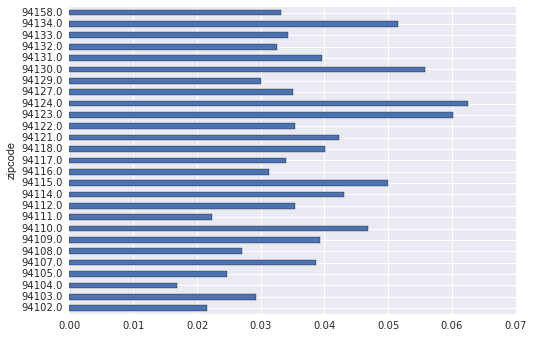

In [66]:
zipgroup.mean()['loss_recorded'].plot(kind='barh')

In [71]:
# the above document shows the likelihood that the estimated_property_loss value 
# is recorded based on zipcode.
# Mission District is within 94103, 94110 zipcodes
# 
zipgroup.mean()['loss_recorded'][94103]

0.029311724689875949

In [72]:
zipgroup.mean()['loss_recorded'][94110]

0.046858983745790013

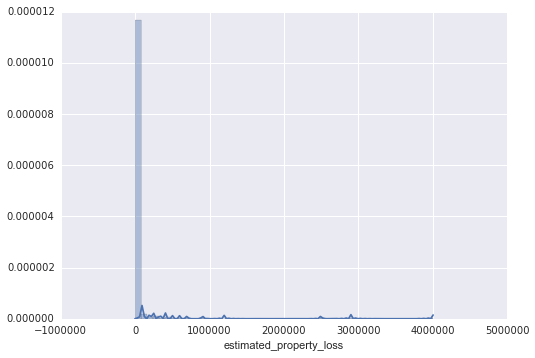

In [74]:
mask = ((df.estimated_property_loss.notnull()) & 
        (df.zipcode == 94110))
sns.distplot(df[mask].estimated_property_loss)

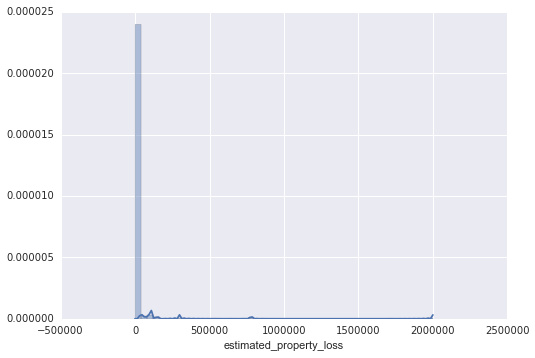

In [75]:
mask = ((df.estimated_property_loss.notnull()) & 
        (df.zipcode == 94103))
sns.distplot(df[mask].estimated_property_loss)

 50         0.163823
 1          0.092150
 500        0.078498
 100        0.078498
 5000       0.075085
 0          0.064846
 1000       0.058020
 10         0.054608
 2000       0.030717
 5          0.027304
 200        0.027304
 10000      0.023891
 25         0.017065
 20         0.013652
 2500       0.013652
 30000      0.013652
 100000     0.010239
 15000      0.010239
 15         0.010239
 750        0.010239
 4000       0.010239
 1500       0.006826
 3000       0.006826
 45         0.006826
 25000      0.006826
 800        0.006826
 73000      0.003413
 2000000    0.003413
 150000     0.003413
 300000     0.003413
 110000     0.003413
 3500       0.003413
 30         0.003413
 40000      0.003413
 600        0.003413
 1442       0.003413
 150        0.003413
 400        0.003413
 1200       0.003413
 35000      0.003413
 120000     0.003413
 350        0.003413
 2250       0.003413
 55000      0.003413
 780000     0.003413
 7000       0.003413
 250        0.003413
 300        0

In [79]:
df['estimated_property_loss'] = pd.to_numeric(df['estimated_property_loss'])

In [84]:
df['estimated_property_loss'] = df['estimated_property_loss'].fillna(0)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 46 columns):
action_taken_other                          32285 non-null object
action_taken_primary                        100000 non-null object
action_taken_secondary                      37405 non-null object
address                                     99902 non-null object
alarm_dttm                                  100000 non-null datetime64[ns]
area_of_fire_origin                         4529 non-null object
arrival_dttm                                99984 non-null datetime64[ns]
automatic_extinguishing_system_present      1154 non-null object
automatic_extinguishing_sytem_perfomance    605 non-null object
city                                        98795 non-null object
civilian_fatalities                         100000 non-null int64
civilian_injuries                           100000 non-null int64
close_dttm                                  100000 non-null datetime64[ns]
detector_

In [89]:
mask = ((df.estimated_property_loss.notnull()) & 
        (df.zipcode == 94103))
df[mask].estimated_property_loss.value_counts(dropna=False, normalize=True, bins=50)

-2010.01       0.9988
 79990.40      0.0004
 39990.20      0.0003
 119990.60     0.0002
 759993.80     0.0001
 279991.40     0.0001
 1959999.80    0.0001
 1679998.40    0.0000
 399992.00     0.0000
 719993.60     0.0000
 679993.40     0.0000
 639993.20     0.0000
 599993.00     0.0000
 559992.80     0.0000
 519992.60     0.0000
 479992.40     0.0000
 439992.20     0.0000
 359991.80     0.0000
 799994.00     0.0000
 319991.60     0.0000
 1759998.80    0.0000
 239991.20     0.0000
 199991.00     0.0000
 159990.80     0.0000
 1799999.00    0.0000
 1839999.20    0.0000
 1879999.40    0.0000
 1719998.60    0.0000
 839994.20     0.0000
 1639998.20    0.0000
 1279996.40    0.0000
 1599998.00    0.0000
 1559997.80    0.0000
 1519997.60    0.0000
 1479997.40    0.0000
 1439997.20    0.0000
 1399997.00    0.0000
 1359996.80    0.0000
 1319996.60    0.0000
 1239996.20    0.0000
 879994.40     0.0000
 1199996.00    0.0000
 1159995.80    0.0000
 1119995.60    0.0000
 1079995.40    0.0000
 1039995.2

In [92]:
df['month'] = df.alarm_dttm.apply(lambda x: x.month)

In [95]:
mask = ((df.month == 6) & (df.year == 2016))
df[mask].describe()

,civilian_fatalities,civilian_injuries,estimated_contents_loss,estimated_property_loss,fire_fatalities,fire_injuries,floor_of_fire_origin,incident_number,number_of_floors_with_extreme_damage,number_of_floors_with_heavy_damage,number_of_floors_with_minimum_damage,number_of_floors_with_significant_damage,number_of_sprinkler_heads_operating,suppression_personnel,suppression_units,zipcode,year,loss_recorded,month
count,2137,2137,63.000000,2137.000000,2137,2137,21.000000,2137.000000,0,0,0,0,2.000000,2137.000000,2137.000000,2114.000000,2137,2137.000000,2137
mean,0,0,25372.793651,1341.536266,0,0,2.000000,16066049.189050,NaN,NaN,NaN,NaN,2.000000,9.253627,2.468882,94113.966887,2016,0.031820,6
std,0,0,139837.004495,54258.589948,0,0,1.048809,3478.935228,NaN,NaN,NaN,NaN,1.414214,7.775241,2.160050,10.727218,0,0.175563,0
min,0,0,0.000000,0.000000,0,0,1.000000,16060113.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,94102.000000,2016,0.000000,6
25%,0,0,10.000000,0.000000,0,0,1.000000,16062990.000000,NaN,NaN,NaN,NaN,1.500000,4.000000,1.000000,94105.000000,2016,0.000000,6
50%,0,0,50.000000,0.000000,0,0,2.000000,16065963.000000,NaN,NaN,NaN,NaN,2.000000,9.000000,2.000000,94110.000000,2016,0.000000,6
75%,0,0,300.000000,0.000000,0,0,3.000000,16069016.000000,NaN,NaN,NaN,NaN,2.500000,11.000000,3.000000,94122.000000,2016,0.000000,6
max,0,0,1000000.000000,2500000.000000,0,0,5.000000,16072142.000000,NaN,NaN,NaN,NaN,3.000000,234.000000,61.000000,94158.000000,2016,1.000000,6


In [96]:
df.describe()

,civilian_fatalities,civilian_injuries,estimated_contents_loss,estimated_property_loss,fire_fatalities,fire_injuries,floor_of_fire_origin,incident_number,number_of_floors_with_extreme_damage,number_of_floors_with_heavy_damage,number_of_floors_with_minimum_damage,number_of_floors_with_significant_damage,number_of_sprinkler_heads_operating,suppression_personnel,suppression_units,zipcode,year,loss_recorded,month
count,100000.000000,100000.000000,4857.000000,100000.000000,100000,100000.000000,1151.000000,100000.000000,432.000000,431.000000,431.000000,429.000000,482.000000,100000.000000,100000.000000,93543.000000,100000.000000,100000.000000,100000.000000
mean,0.000030,0.001140,8076.845501,1264.292410,0,0.000250,2.002606,14413858.810870,0.125000,0.157773,0.700696,0.209790,0.267635,9.315160,2.595610,94113.901756,2014.349240,0.036680,6.402650
std,0.005477,0.058127,163792.416829,130368.251155,0,0.021678,2.054685,1030120.261477,0.479873,0.455640,0.524714,0.440685,1.060023,7.004068,8.021293,10.391688,1.036881,0.187976,3.411947
min,0.000000,0.000000,-7.000000,-25000.000000,0,0.000000,-3.000000,13014518.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94102.000000,2013.000000,0.000000,1.000000
25%,0.000000,0.000000,10.000000,0.000000,0,0.000000,1.000000,13115656.750000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,94105.000000,2013.000000,0.000000,4.000000
50%,0.000000,0.000000,50.000000,0.000000,0,0.000000,2.000000,14118095.500000,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,2.000000,94111.000000,2014.000000,0.000000,6.000000
75%,0.000000,0.000000,200.000000,0.000000,0,0.000000,2.000000,15098423.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.000000,3.000000,94121.000000,2015.000000,0.000000,9.000000
max,1.000000,9.000000,10000000.000000,40000000.000000,0,4.000000,29.000000,16078074.000000,6.000000,4.000000,4.000000,3.000000,20.000000,234.000000,2257.000000,94158.000000,2016.000000,1.000000,12.000000


In [97]:
df.alarm_dttm.min()

Timestamp('2013-02-12 04:52:17')

In [98]:
df.alarm_dttm.max()

Timestamp('2016-07-15 23:02:08')

In [ ]:
# what is odd is how the fire civilian fatalities have a max value of 1, which makes it concerning that the dataset
# is inaccurate and needs to be cleaned more carefully before we proceed.
